In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
import torch.nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
!pip install torchinfo
from torchinfo import summary
import copy

# Step #1: Load, Preprocess, Analyze, Vizualize datset

In [4]:

#Step1: preprocessing the dataset


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Ensure 3 channels for RGB-like input
    transforms.Resize((28, 28)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

#setting values
batch_size = 60

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training_dataset = ImageFolder(root='/kaggle/input/cnn-dataset/cnn_dataset',transform=transform)

#splitting th data into 80% for training and 20% for validation
training_size = int(len(training_dataset) * 0.8)  # 80% for training
validation_size = int(len(training_dataset) * 0.1)  # 10% for validation
testing_size =  len(training_dataset) - training_size - validation_size

train_dataset, val_dataset, test_dataset = random_split(training_dataset, [training_size, validation_size, testing_size], generator=torch.Generator().manual_seed(42))

# creating the dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# Key Statistics

In [20]:
# Convert to numpy arrays for easier analysis
data = [training_dataset[i][0].numpy().squeeze() for i in range(len(training_dataset))]
labels = [training_dataset[i][1] for i in range(len(training_dataset))]

# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

samples = len(labels)
image_height, image_width = data.shape[1], data.shape[2]
classes = len(np.unique(labels))

print(f"Number of Samples: {samples}")
print(f"Image Dimensions: {image_height} x {image_width}")
print(f"Number of Classes: {classes}")

count_of_classes = pd.Series(labels).value_counts().sort_index()

#pixel stats
pixel_mean = np.mean(data)
pixel_std = np.std(data)
pixel_min = np.min(data)
pixel_max = np.max(data)

print(f"\nPixel Statistics:")
print(f"Mean: {pixel_mean:.4f}")
print(f"Standard Deviation: {pixel_std:.4f}")
print(f"Min Pixel Value: {pixel_min}")
print(f"Max Pixel Value: {pixel_max}")



Number of Samples: 100800
Image Dimensions: 3 x 28
Number of Classes: 36

Pixel Statistics:
Mean: -0.6484
Standard Deviation: 0.6674
Min Pixel Value: -1.0
Max Pixel Value: 1.0


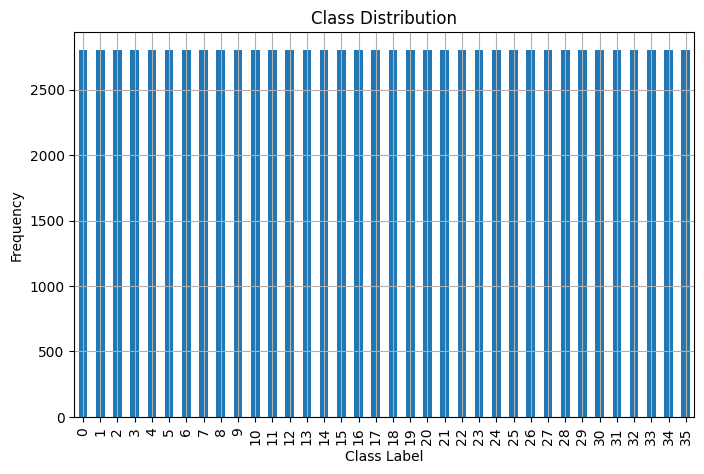

In [26]:
#Class Distribution
plt.figure(figsize=(8, 5))
count_of_classes.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

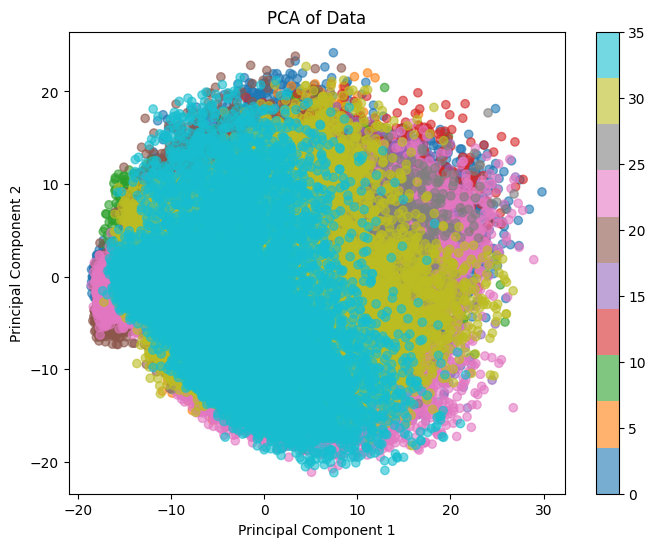

In [21]:
from sklearn.decomposition import PCA

flat_data = data.reshape(data.shape[0], -1)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(flat_data)
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='tab10', alpha=0.6)
plt.colorbar()
plt.title("PCA of Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


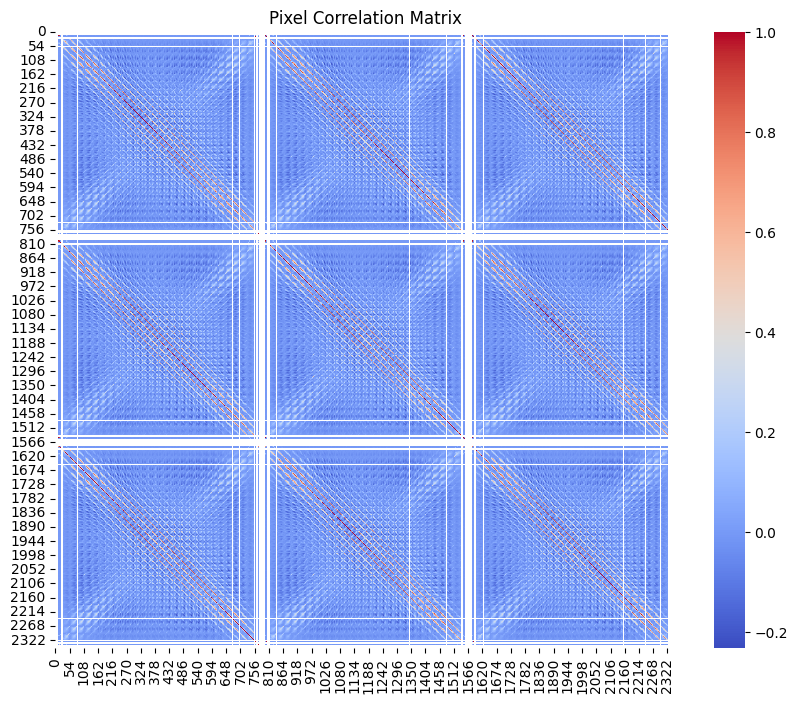

In [23]:
#Correlation Matrix of Pixels
corr_matrix = np.corrcoef(flat_data.T)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', cbar=True)
plt.title("Pixel Correlation Matrix")
plt.show()

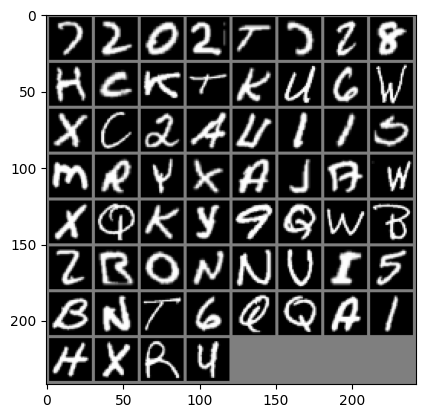

7     2     0     2     T     J     2     8     H     C     K     T     K     U     6     W     X     G     2     A     U     1     1     5     M     R     Y     X     A     J     A     W     X     Q     K     Y     9     Q     W     B     Z     B     O     N     N     U     I     5     B     N     T     6     Q     Q     A     L     H     X     R     4    


In [27]:
#vizualize the training data

# classes = ('0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z')
classes = (training_dataset.classes)

# function to show an image from quiz 5
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
#intialize arrays to stores loss values and collect accuracies
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []
avg_validation_accuracy = 0
total_training_labels = []
total_training_predictions = []
total_validation_labels = []
total_validation_predictions = []

start_time = time.time()
training_epoch_accuracy = 0
validation_epoch_accuracy = 0


In [7]:
print(torch.cuda.is_available())

True


# Step #2 and #3:Build and train basic CNN model. 

In [8]:

class CNNModel(nn.Module):
    def __init__(self, num_classes=36):
        super(CNNModel, self).__init__()
        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  #orginial
        
        self.fc1 = nn.Linear(128 * 3 * 3, 1024)  # 3 conv layers and 2 max-pool
        self.fc2 = nn.Linear(1024, num_classes)  # Final output layer 36 categories

        # Dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))
        
        x = x.view(-1, 128 * 3 * 3)  # Flatten for fully connected layer
        
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Initialize the model, loss function, and optimizer
model = CNNModel(num_classes=36).to(device)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training Phase
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    batch_training_loss = 0.0
    correct_train_length = 0
    total_train_length = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_training_loss += loss.item()
        
        _, predicted_train =  torch.max(outputs.data,1)  
        total_train_length += labels.size(0)
        correct_train_length += (predicted_train == labels).sum().item()
    
    train_loss = batch_training_loss / len(train_dataloader)
    training_epoch_accuracy = 100 * (correct_train_length / total_train_length)
    train_losses.append(train_loss)
    train_accuracies.append(training_epoch_accuracy)

   #Validation Phase
    model.eval()  #evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            
            val_loss += criterion(val_outputs, val_labels).item()

            _, predicted_val = torch.max(val_outputs.data, 1) 
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()

    validation_loss = val_loss / len(val_dataloader)
    validation_epoch_accuracy = 100 * (correct_val / total_val)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_epoch_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {training_epoch_accuracy:.2f}%, "
              f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_epoch_accuracy:.2f}%")


end_time = time.time()
training_time = end_time - start_time  #total training time
print(f"Total Training Time: {training_time:.2f} seconds")



Epoch 1/10, Train Loss: 0.5594, Train Accuracy: 81.46%, Validation Loss: 0.2894, Validation Accuracy: 89.05%
Epoch 2/10, Train Loss: 0.2923, Train Accuracy: 89.16%, Validation Loss: 0.2510, Validation Accuracy: 90.54%
Epoch 3/10, Train Loss: 0.2550, Train Accuracy: 90.32%, Validation Loss: 0.2449, Validation Accuracy: 90.92%
Epoch 4/10, Train Loss: 0.2294, Train Accuracy: 91.10%, Validation Loss: 0.2219, Validation Accuracy: 91.48%
Epoch 5/10, Train Loss: 0.2113, Train Accuracy: 91.71%, Validation Loss: 0.2318, Validation Accuracy: 91.19%
Epoch 6/10, Train Loss: 0.1970, Train Accuracy: 92.10%, Validation Loss: 0.2322, Validation Accuracy: 91.48%
Epoch 7/10, Train Loss: 0.1866, Train Accuracy: 92.48%, Validation Loss: 0.2307, Validation Accuracy: 91.53%
Epoch 8/10, Train Loss: 0.1728, Train Accuracy: 92.82%, Validation Loss: 0.2401, Validation Accuracy: 91.38%
Epoch 9/10, Train Loss: 0.1666, Train Accuracy: 93.00%, Validation Loss: 0.2357, Validation Accuracy: 91.61%
Epoch 10/10, Train 

# Step #5 Summary of the model using Torchinfo

In [28]:
summary(model)
print(model)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=36, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


# Step #4: Adding the improvement methods from part II - Step 4

Method #1: Early stopping from part 2

In [9]:

# Initialize the model, loss function, and optimizer
model_early_stopping = CNNModel(num_classes=36).to(device)
criterion_early_stopping = nn.CrossEntropyLoss()  # For multi-class classification
optimizer_early_stopping = optim.Adam(model_early_stopping.parameters(), lr=0.001)

start_time = time.time()

train_losses_early_stopping = []
validation_losses_early_stopping = []
train_accuracies_early_stopping = []
validation_accuracies_early_stopping = []
avg_validation_accuracy_early_stopping = 0
total_training_labels_early_stopping = []
total_training_predictions_early_stopping = []
total_validation_labels_early_stopping = []
total_validation_predictions_early_stopping = []
training_epoch_accuracy_early_stopping = 0
validation_epoch_accuracy_early_stopping = 0


# Variables used for Early Stopping
best_loss = float('inf')
counter = 0
best_validation_loss = 0.0

best_validation_accuracy = 0.0

# Training Phase
num_epochs = 10
for epoch in range(num_epochs):
    model_early_stopping.train()
    batch_training_loss = 0.0
    correct_train_length = 0
    total_train_length = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_early_stopping(images)
        loss = criterion_early_stopping(outputs, labels)

        # Backward pass and optimization
        optimizer_early_stopping.zero_grad()
        loss.backward()
        optimizer_early_stopping.step()
        
        batch_training_loss += loss.item()
        
        _, predicted_train =  torch.max(outputs.data,1)  
        total_train_length += labels.size(0)
        correct_train_length += (predicted_train == labels).sum().item()
    
    train_loss_early_stopping = batch_training_loss / len(train_dataloader)
    training_epoch_accuracy_early_stopping = 100 * (correct_train_length / total_train_length)
    train_losses_early_stopping.append(train_loss_early_stopping)
    train_accuracies_early_stopping.append(training_epoch_accuracy_early_stopping)

   #Validation Phase
    model_early_stopping.eval()  
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model_early_stopping(val_inputs)
            
            val_loss += criterion_early_stopping(val_outputs, val_labels).item()

            _, predicted_val = torch.max(val_outputs.data, 1) 
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()

    validation_loss_early_stopping = val_loss / len(val_dataloader)
    validation_epoch_accuracy_early_stopping = 100 * (correct_val / total_val)
    validation_losses_early_stopping.append(validation_loss_early_stopping)
    validation_accuracies_early_stopping.append(validation_epoch_accuracy_early_stopping)
    
    if val_loss < best_validation_loss:
        print(f"Validation loss is {val_loss:.4f} from {best_validation_loss:.4f}")
        best_validation_loss = val_loss
        best_epoch = epoch + 1
        best_model_weight = model_early_stopping.state_dict()
        
     #Saving best model weights 
    if validation_epoch_accuracy_early_stopping > best_validation_accuracy:
        best_validation_accuracy = validation_epoch_accuracy_early_stopping
        torch.save(model.state_dict(),'best_weights_cnn_early_stopping.pth')
        print(f"Best model weights with highest validation accuracy saved at best_weights_cnn_early_stopping.pth at epoch {epoch+1}")
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss_early_stopping:.4f}, Train Accuracy: {training_epoch_accuracy_early_stopping:.2f}%, "
              f"Validation Loss: {validation_loss_early_stopping:.4f}, Validation Accuracy: {validation_epoch_accuracy_early_stopping:.2f}%")
    
    
    # Early stopping method
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_weights = copy.deepcopy(model_early_stopping.state_dict())
        counter = 10  # Reset patience counter
    else:
        counter -= 1
        if counter == 0:
            break

end_time = time.time()
training_time = end_time - start_time  #total training time
print(f"Total Training Time: {training_time:.2f} seconds")


Best model weights with highest validation accuracy saved at best_weights_cnn_early_stopping.pth at epoch 1
Epoch 1/10, Train Loss: 0.5505, Train Accuracy: 81.68%, Validation Loss: 0.2846, Validation Accuracy: 89.50%
Best model weights with highest validation accuracy saved at best_weights_cnn_early_stopping.pth at epoch 2
Epoch 2/10, Train Loss: 0.2890, Train Accuracy: 89.32%, Validation Loss: 0.2528, Validation Accuracy: 89.99%
Best model weights with highest validation accuracy saved at best_weights_cnn_early_stopping.pth at epoch 3
Epoch 3/10, Train Loss: 0.2516, Train Accuracy: 90.42%, Validation Loss: 0.2425, Validation Accuracy: 90.69%
Best model weights with highest validation accuracy saved at best_weights_cnn_early_stopping.pth at epoch 4
Epoch 4/10, Train Loss: 0.2282, Train Accuracy: 91.25%, Validation Loss: 0.2343, Validation Accuracy: 90.89%
Best model weights with highest validation accuracy saved at best_weights_cnn_early_stopping.pth at epoch 5
Epoch 5/10, Train Loss: 

Method #2: Learning Rate Scheduler

In [15]:

# Initialize the model, loss function, and optimizer
model_lr_scheduler = CNNModel(num_classes=36).to(device)
criterion_lr_scheduler = nn.CrossEntropyLoss()  # For multi-class classification
optimizer_lr_scheduler = optim.Adam(model_lr_scheduler.parameters(), lr=0.001)

best_validation_loss = 0.0
best_validation_accuracy = 0.0

start_time = time.time()

#learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4)

train_losses_lr = []
validation_losses_lr = []
train_accuracies_lr = []
validation_accuracies_lr = []
avg_validation_accuracy_lr = 0
total_training_labels_lr = []
total_training_predictions_lr = []
total_validation_labels_lr = []
total_validation_predictions_lr = []
training_epoch_accuracy_lr = 0
validation_epoch_accuracy_lr = 0


# Training Phase
num_epochs = 10
for epoch in range(num_epochs):
    model_lr_scheduler.train()
    batch_training_loss = 0.0
    correct_train_length = 0
    total_train_length = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_lr_scheduler(images)
        loss = criterion_lr_scheduler(outputs, labels)

        # Backward pass and optimization
        optimizer_lr_scheduler.zero_grad()
        loss.backward()
        optimizer_lr_scheduler.step()
        
        batch_training_loss += loss.item()
        
        _, predicted_train =  torch.max(outputs.data,1)  
        total_train_length += labels.size(0)
        correct_train_length += (predicted_train == labels).sum().item()
    
    train_loss_lr = batch_training_loss / len(train_dataloader)
    training_epoch_accuracy_lr = 100 * (correct_train_length / total_train_length)
    train_losses_lr.append(train_loss_lr)
    train_accuracies_lr.append(training_epoch_accuracy_lr)

   #Validation Phase
    model_lr_scheduler.eval()  #evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model_lr_scheduler(val_inputs)
            
            val_loss += criterion_lr_scheduler(val_outputs, val_labels).item()

            _, predicted_val = torch.max(val_outputs.data, 1) 
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()

    validation_loss_lr = val_loss / len(val_dataloader)
    validation_epoch_accuracy_lr = 100 * (correct_val / total_val)
    validation_losses_lr.append(validation_loss_lr)
    validation_accuracies_lr.append(validation_epoch_accuracy_lr)
    
    if val_loss < best_validation_loss:
        print(f"Validation loss is {val_loss:.4f} from {best_validation_loss:.4f}")
        best_validation_loss = val_loss
        best_epoch = epoch + 1
        best_model_weight = model_lr_scheduler.state_dict()
        
    #Saving best model weights 
    if validation_epoch_accuracy_lr > best_validation_accuracy:
        best_validation_accuracy = validation_epoch_accuracy_lr
        torch.save(model.state_dict(),'best_weights_cnn_lr.pth')
        print(f"Best model weights with highest validation accuracy saved at best_weights_cnn_lr.pth at epoch {epoch+1}")
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss_lr:.4f}, Train Accuracy: {training_epoch_accuracy_lr:.2f}%, "
              f"Validation Loss: {validation_loss_lr:.4f}, Validation Accuracy: {validation_epoch_accuracy_lr:.2f}%")
    
    #update the learning rate
    scheduler.step(val_loss)


end_time = time.time()
training_time = end_time - start_time  #total training time
print(f"Total Training Time: {training_time:.2f} seconds")



Best model weights with highest validation accuracy saved at best_weights_cnn_lr.pth at epoch 1
Epoch 1/10, Train Loss: 0.5516, Train Accuracy: 81.69%, Validation Loss: 0.2845, Validation Accuracy: 89.59%
Best model weights with highest validation accuracy saved at best_weights_cnn_lr.pth at epoch 2
Epoch 2/10, Train Loss: 0.2903, Train Accuracy: 89.29%, Validation Loss: 0.2438, Validation Accuracy: 90.96%
Epoch 3/10, Train Loss: 0.2497, Train Accuracy: 90.55%, Validation Loss: 0.2524, Validation Accuracy: 90.46%
Epoch 4/10, Train Loss: 0.2298, Train Accuracy: 91.09%, Validation Loss: 0.2520, Validation Accuracy: 90.47%
Epoch 5/10, Train Loss: 0.2116, Train Accuracy: 91.53%, Validation Loss: 0.2456, Validation Accuracy: 90.78%
Best model weights with highest validation accuracy saved at best_weights_cnn_lr.pth at epoch 6
Epoch 6/10, Train Loss: 0.1979, Train Accuracy: 91.98%, Validation Loss: 0.2280, Validation Accuracy: 91.52%
Epoch 7/10, Train Loss: 0.1857, Train Accuracy: 92.39%, Va

Method #3: Data Augmentation

In [29]:

# updated data augmentation with more parameters and changed normalization
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize images to 28x28 (if not already)
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(15),  # Random rotation up to 15 degrees
    transforms.RandomAffine(10, shear=10),  # Random affine transformation (rotate, scale, shear)
    transforms.RandomCrop(28, padding=4),  # Random crop with padding to add variability
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  
    transforms.RandomVerticalFlip(),  # Random vertical flip
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, interpolation=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization for grayscale
])

# #updated the batch size 
data_augmented_batch_size = 150
training_dataset = ImageFolder(root='/kaggle/input/cnn-dataset/cnn_dataset',transform=transform)

#splitting th data into 80% for training and 10% for validation
training_size = int(len(training_dataset) * 0.8)  # 80% for training
validation_size = int(len(training_dataset) * 0.1)  # 10% for validation
testing_size =  len(training_dataset) - training_size - validation_size

train_dataset, val_dataset, test_dataset = random_split(training_dataset, [training_size, validation_size, testing_size], generator=torch.Generator().manual_seed(42))

# creating the dataloaders
train_dataloader = DataLoader(dataset=train_dataset, batch_size=data_augmented_batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=data_augmented_batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model_data_augumented = CNNModel(num_classes=36).to(device)
criterion_data_augumented = nn.CrossEntropyLoss()  # For multi-class classification
optimizer_data_augumented = optim.AdamW(model_data_augumented.parameters(), lr=0.0001)


start_time = time.time()

train_losses_data_augmented = []
validation_losses_data_augmented = []
train_accuracies_data_augmented = []
validation_accuracies_data_augmented = []
avg_validation_accuracy_data_augmented = 0
total_training_labels_data_augmented = []
total_training_predictions_data_augmented = []
total_validation_labels_data_augmented = []
total_validation_predictions_data_augmented = []
training_epoch_accuracy_data_augmented = 0
validation_epoch_accuracy_data_augmented = 0

best_validation_loss = 0.0

# Training Phase
num_epochs = 5
for epoch in range(num_epochs):
    model_data_augumented.train()
    batch_training_loss = 0.0
    correct_train_length = 0
    total_train_length = 0

    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_data_augumented(images)
        loss = criterion_data_augumented(outputs, labels)

        # Backward pass and optimization
        optimizer_data_augumented.zero_grad()
        loss.backward()
        optimizer_data_augumented.step()
        
        batch_training_loss += loss.item()
        
        _, predicted_train =  torch.max(outputs.data,1)  
        total_train_length += labels.size(0)
        correct_train_length += (predicted_train == labels).sum().item()
    
    train_loss_data_augmented = batch_training_loss / len(train_dataloader)
    training_epoch_accuracy_data_augmented = 100 * (correct_train_length / total_train_length)
    train_losses_data_augmented.append(train_loss_data_augmented)
    train_accuracies_data_augmented.append(training_epoch_accuracy_data_augmented)

   #Validation Phase
    model_data_augumented.eval()  #evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in val_dataloader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model_data_augumented(val_inputs)
            
            val_loss += criterion_data_augumented(val_outputs, val_labels).item()

            _, predicted_val = torch.max(val_outputs.data, 1) 
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()

    validation_loss_data_augmented = val_loss / len(val_dataloader)
    validation_epoch_accuracy_data_augmented = 100 * (correct_val / total_val)
    validation_losses_data_augmented.append(validation_loss_data_augmented)
    validation_accuracies_data_augmented.append(validation_epoch_accuracy_data_augmented)
    
    if val_loss < best_validation_loss:
        print(f"Validation loss is {val_loss:.4f} from {best_validation_loss:.4f}")
        best_validation_loss = val_loss
        best_epoch = epoch + 1
        best_model_weight = model_data_augumented.state_dict()
    
    print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss_data_augmented:.4f}, Train Accuracy: {training_epoch_accuracy_data_augmented:.2f}%, "
              f"Validation Loss: {validation_loss_data_augmented:.4f}, Validation Accuracy: {validation_epoch_accuracy_data_augmented:.2f}%")
    

end_time = time.time()
training_time = end_time - start_time  #total training time
print(f"Total Training Time: {training_time:.2f} seconds")



Epoch 1/5, Train Loss: 2.7441, Train Accuracy: 19.20%, Validation Loss: 2.0242, Validation Accuracy: 39.46%
Epoch 2/5, Train Loss: 1.9093, Train Accuracy: 39.27%, Validation Loss: 1.6343, Validation Accuracy: 49.55%
Epoch 3/5, Train Loss: 1.6346, Train Accuracy: 47.67%, Validation Loss: 1.4430, Validation Accuracy: 55.48%
Epoch 4/5, Train Loss: 1.4578, Train Accuracy: 52.99%, Validation Loss: 1.3314, Validation Accuracy: 57.94%
Epoch 5/5, Train Loss: 1.3367, Train Accuracy: 56.90%, Validation Loss: 1.1697, Validation Accuracy: 63.05%
Total Training Time: 1026.78 seconds


# Testing the dataset with the best performed model

In [16]:
#Testing phase
# testing_dataset = ImageFolder(root='/kaggle/input/cnn-dataset',transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=60, shuffle=False)  #using the batch size from the orginial model as that is what we trained with

model_lr_scheduler.eval()
predicted_list = []
test_list = []
test_total_loss = 0.0
avg_test_accuracy = 0
test_epoch_accuracy = 0
test_accuracies = []
test_losses = []
actual_test_labels = []

correct = 0
total  = 0


with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model_lr_scheduler(test_inputs)
        test_total_loss += criterion_lr_scheduler(test_outputs, test_labels).item()
        
        _, predicted = torch.max(test_outputs, 1)
        predicted_test_probs = torch.softmax(test_outputs, dim=1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()
        
        test_list.extend(predicted.cpu().numpy())
        predicted_list.extend(predicted_test_probs.cpu().numpy())
        actual_test_labels.extend(test_labels.cpu().numpy())


test_list = np.array(test_list)
predicted_list = np.array(predicted_list)
actual_test_labels = np.array(actual_test_labels)
test_loss = test_total_loss / len(test_loader)      
test_epoch_accuracy = 100 *  (correct / total)

# test_losses.append(test_loss)
# test_accuracies.append(test_epoch_accuracy)
    
#     print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_epoch_accuracy:.2f}%,")
        

# accuracy = accuracy_score(test_list, predicted_list) * 100
precision, recall, f1, _ = precision_recall_fscore_support(actual_test_labels, test_list, average='weighted')

print(f"Accuracy: {test_epoch_accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Accuracy: 91.0119, Precision: 0.9139, Recall: 0.9101, F1: 0.9093


Test Loss: [0.2632115816786176, 0.2632115816786176, 0.2632115816786176, 0.2632115816786176, 0.2632115816786176, 0.2632115816786176, 0.2632115816786176, 0.2632115816786176, 0.2632115816786176, 0.2632115816786176]


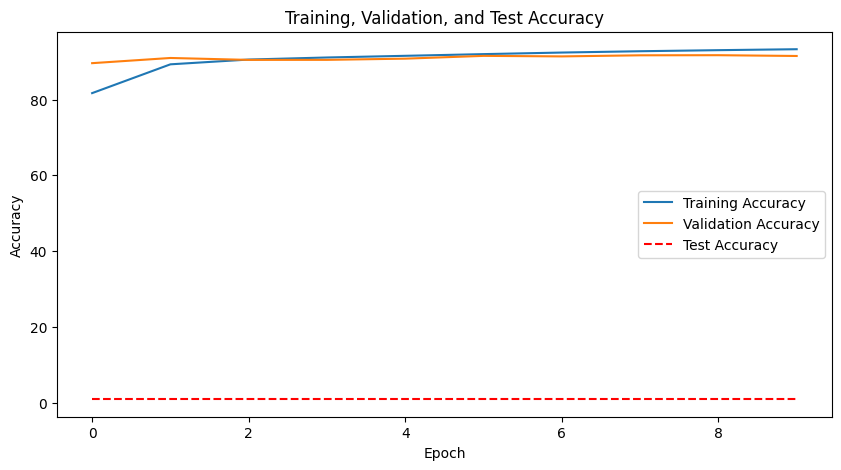

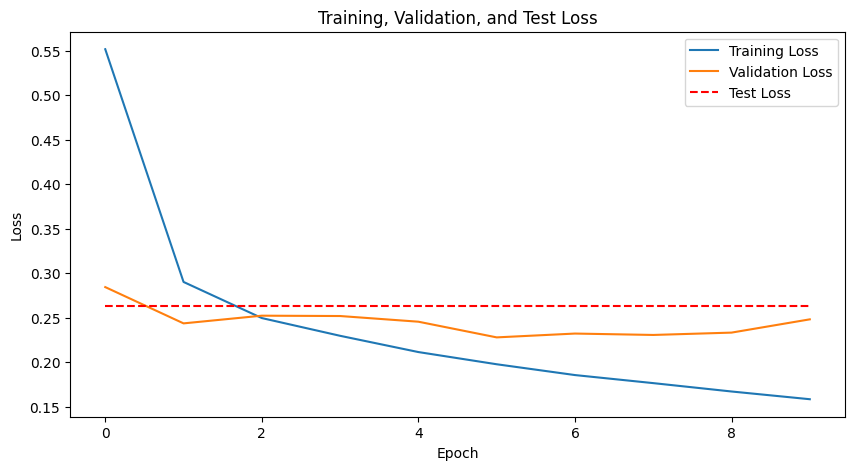

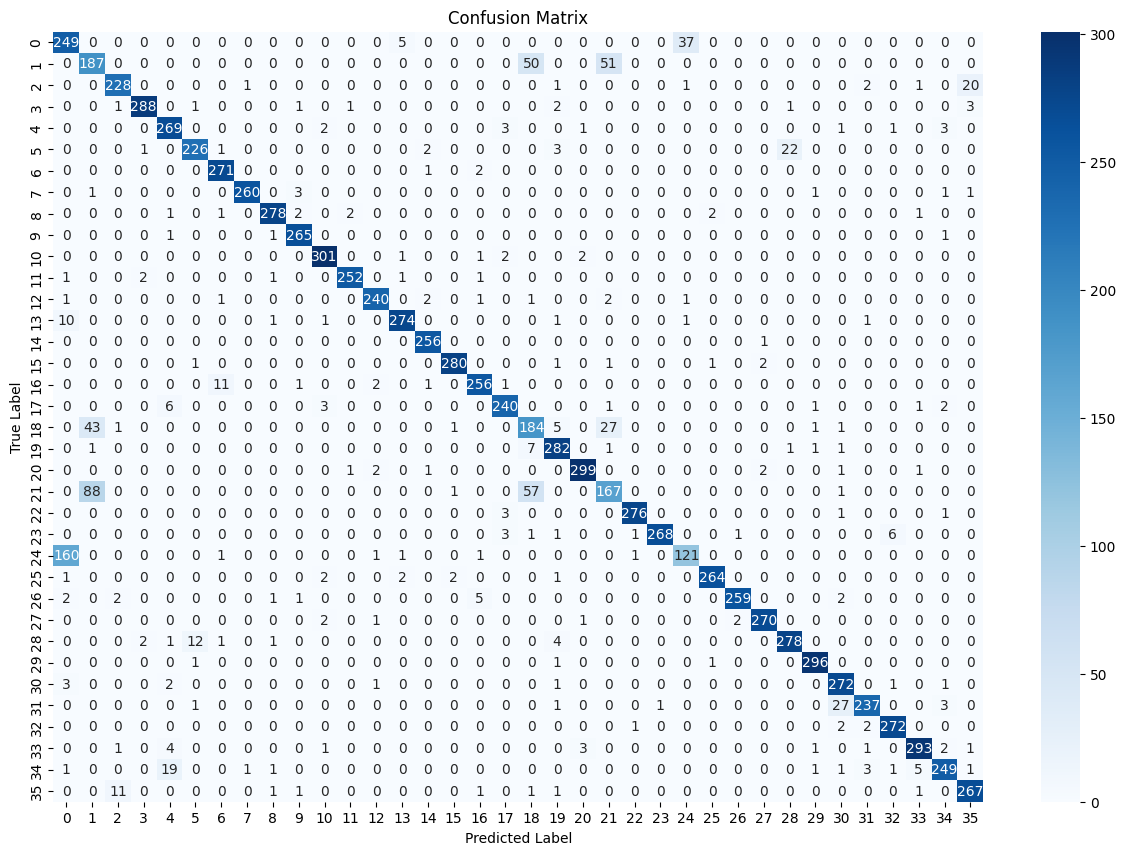

In [25]:
test_accuracies = [test_epoch_accuracy / 100] * num_epochs
test_losses = [test_loss] * num_epochs
print('Test Loss:',test_losses)

#Training,Validation and Test Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies_lr, label='Training Accuracy')
plt.plot(validation_accuracies_lr, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy', linestyle='--', color='red')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Training,Validation and Test Loss graph
plt.figure(figsize=(10, 5))
plt.plot(train_losses_lr, label='Training Loss')
plt.plot(validation_losses_lr, label='Validation Loss')
plt.plot(test_losses, label='Test Loss', linestyle='--', color='red')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Confusion Matrix
conf_matrix = confusion_matrix(actual_test_labels, test_list)
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


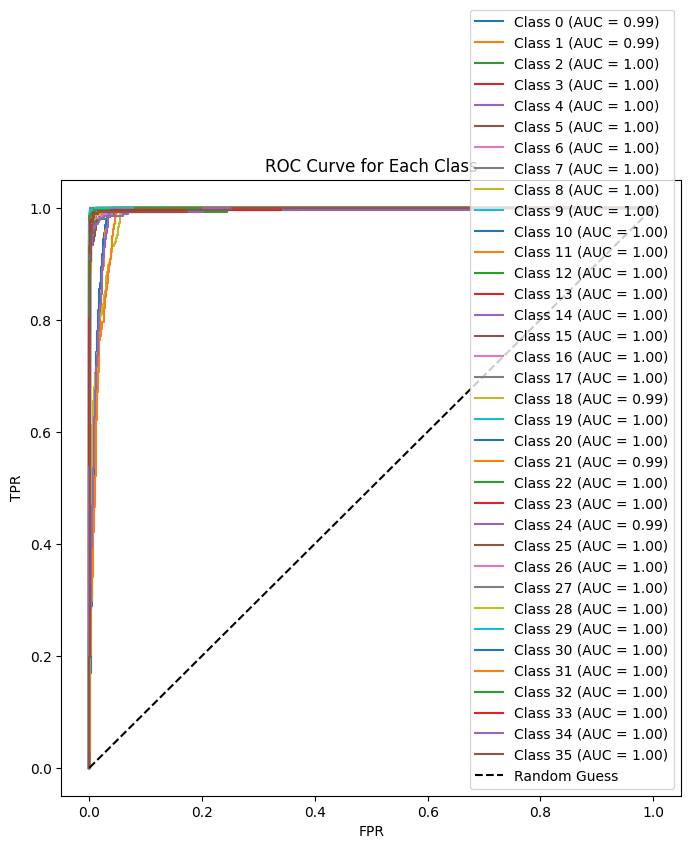

In [19]:


#plotting the ROC curve
plt.figure(figsize=(8,8))
test_dataset_labels_binarized = label_binarize(actual_test_labels, classes=np.arange(36))
fpr = {}
tpr = {}
roc_auc = {}

# 36 is the num classes
for i in range(36):
    fpr[i], tpr[i], _ = roc_curve(test_dataset_labels_binarized[:, i], predicted_list[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=f'Class {i}').plot(ax=plt.gca())
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve for Each Class')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.show()